In [1]:
from make_it_talk.models import *
from make_it_talk.scripts import *

/Users/antonbeletsky/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/antonbeletsky/opt/anaconda3/lib/python3.9/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
batch_size = 8
time = 32
h = 30
w = 40
audio_dim = 256

#simple dataloader-plug
init_pictures = torch.rand((batch_size, h, w))
audios = torch.rand((batch_size, time, audio_dim))
true_videos = torch.rand((batch_size, time, h, w))

batch = (init_pictures, audios, true_videos)
loader = [batch]

In [3]:
# here we just make sure that everything has different dimensions so we are not confusing them in our code

content_emb_dim = 100
speaker_dim = 101
lstm_content_dim = 102
lstm_speaker_dim = 103
mlp_speaker_dim = 104
attn_dim = 105

lm_dim  = 68 * 3

pipeline = make_talking_head_pipeline(
    audio_to_embedding = AudioToEmbeddingPlug(audio_dim, content_emb_dim, speaker_dim), # returns 100, 101
    lstm_speech_content = LSTMSpeechContentPlug(content_emb_dim, lstm_content_dim),
    lstm_speaker_aware = LSTMSpeakerAwarePlug(content_emb_dim, lstm_speaker_dim),
    mlp_speaker_embedding = MLPSpeakerEmbeddingPlug(speaker_dim, mlp_speaker_dim),
    self_attention_encoder = SelfAttentionEncoderPlug(lstm_speaker_dim + mlp_speaker_dim, attn_dim),
    facial_landmarks_extractor = FacialLandmarksExtractorPlug(h, w),
    mlp_speaker_aware = MLPSpeakerPlug(attn_dim + lm_dim, lm_dim),
    mlp_speech_content = MLPContentPlug(lstm_content_dim + lm_dim, lm_dim),
    discriminator = DiscriminatorPlug(lm_dim, lstm_speaker_dim, mlp_speaker_dim)
)

In [4]:
#check that pipeline works

device='cpu'

pictures, audios, true_videos = batch

audios = audios.to(device)
pictures = pictures.to(device)
true_videos = true_videos.to(device)

predicted_landmarks, discriminator_input = pipeline(audios, pictures)

realism = pipeline.discriminator(*discriminator_input)

In [5]:
# check that train loop for content predictor works

optimizer = torch.optim.Adam(params=pipeline.content_landmarks_predictor.parameters(), lr=1e-3)
loss_fn = (lambda x, y : ((x - y)**2).mean())
metric_fn = (lambda x, y : ((x - y)**2).mean())

log = train_content_landmarks_predictor(
        talking_head_pipeline=pipeline,
        optimizer=optimizer,
        dataloader=loader,
        n_epochs=300,
        device=device,
        loss_function=loss_fn,
        metrics_list=[metric_fn],
        training_log=None,
)

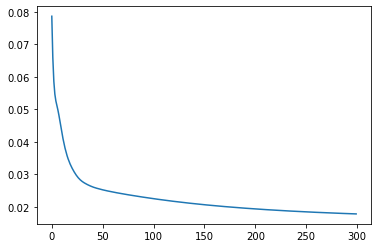

In [6]:
# check that loss drops with time
losses = [l['loss'] for l in log]
import matplotlib.pyplot as plt
plt.plot(losses)

In [7]:
# check that train loop for generator-discriminator pair works

generator_optimizer = torch.optim.Adam(params=pipeline.personal_landmarks_predictor.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(params=pipeline.discriminator.parameters(), lr=1e-4)

gen_loss_fn = (lambda pred, realism, true: ((pred - true)**2).mean() + ((realism - 1)**2).mean())
discr_loss_fn = (lambda pred, true: ((true - 1)**2).mean() + (pred**2).mean())

log = train_pipeline(
    talking_head_pipeline = pipeline,
    generator_optimizer = generator_optimizer,
    discriminator_optimizer = discriminator_optimizer,
    train_dataloader = loader,
    n_epochs = 100,
    device = device,
    generator_loss_function = gen_loss_fn,
    discriminator_loss_function = discr_loss_fn,
    metrics_list = [],
    training_log=None,
)

In [8]:
losses = {'generator_loss': [], 'discriminator_loss': []}

for epoch in log:
    for name in epoch:
        if name == 'metrics':
            continue
        if epoch[name]:
            losses[name].append(epoch[name])

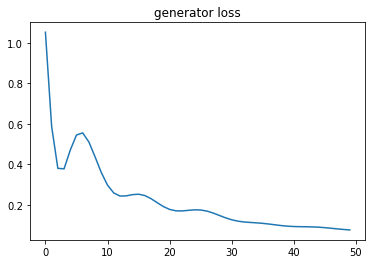

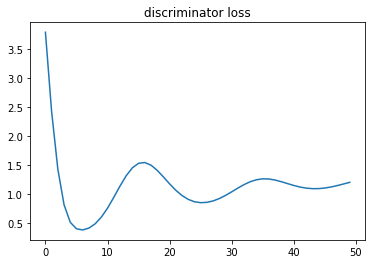

In [9]:
# check that losses drop with time

plt.figure()
plt.plot(losses['generator_loss'])
plt.title('generator loss')
plt.show()
plt.figure()
plt.plot(losses['discriminator_loss'])
plt.title('discriminator loss')
plt.show()